# **Introduction to Word2Vec**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sekhansen/text_algorithms_econ/blob/main/notebooks/4_word2vec.ipynb)

Now that we’ve explored the theoretical foundations of Word2Vec, let’s shift to a hands-on application. In this section, we’ll implement Word2Vec using an off-the-shelf Python library, ```Gensim``` — a robust and widely used toolkit for unsupervised topic modeling and natural language processing. See documentation [here](https://radimrehurek.com/gensim/models/word2vec.html).

We’ll walk through:
- Training a Word2Vec model using Gensim
- Exploring the learned word embeddings through visualization, nearest neighbor analysis, analogy tasks and building dictionaries.

Let’s get started!
<br><br>

# ⚙️ Setup
Install and import required libraries for preprocessing, modeling, and visualization.

In [ ]:
# install required libraries
!pip3 install flashtext                  # easy phrase replacing methods
!pip3 install contractions               # expand English contractions
!pip3 install spacy                      # functions for lemmatizing
!pip3 install gensim==4.0.0              # word2vec estimation
!pip3 install adjustText                 # generate plots with lots of text labels
!pip3 install gdown                      # download files from Google Drive
!pip3 install nltk                       # NLP library

# install Spacy's language model
# for more languages and models check: https://spacy.io/models
!python3 -m spacy download en_core_web_sm

In [1]:
# import libraries
import sys
import pandas as pd
import numpy as np
import string
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
from adjustText import adjust_text
from sklearn.decomposition import PCA
from collections import Counter
from sklearn.preprocessing import StandardScaler

In [41]:
# load data from Google Drive
file_id = '1VzmiPSENUfqLaFG7ff3GmXJJKnvenGIe'
url = f'https://drive.google.com/uc?id={file_id}'
df = pd.read_csv(url, header=None, names=['text'])

# Split each line into a list of tokens
df['tokens'] = df['text'].str.split()
preprocessed_tokens = df['tokens'].tolist()

# 🧠 Off-the-shelf Word2Vec using Gensim

[Gensim](https://radimrehurek.com/gensim/index.html) provides a fast and memory-efficient implementation of Word2Vec.
Below, we’ll train a model on our preprocessed corpus and explore the learned word vectors.

## 🔧 Model Estimation

With our tokenized corpus ready, let's estimate a Word2Vec model using Gensim’s `Word2Vec` class.
This step will train the model using either the Skip-gram or CBOW approach (default: Skip-gram).

In [8]:
# train Gensim's Word2Vec model (takes less than a minute)
gensim_model = Word2Vec(sentences=preprocessed_tokens,      # corpus
                        vector_size=100,            # embedding dimension
                        window=5,                   # words before and after to take into consideration
                        sg=1,                       # use skip-gram
                        negative=10,                # number of negative examples for each positive one
                        alpha=0.025,                # initial learning rate
                        min_alpha=0.0001,           # minimum learning rate
                        epochs=5,                   # number of passes through the data
                        min_count=1,                # words that appear less than this are removed
                        workers=1,                  # we use 1 to ensure replicability
                        seed=92                     # for replicability
                       )

### 📌 Understanding Model Parameters
`Word2Vec` includes several important hyperparameters:
- `sentences`: The input corpus, a list of tokenized sentences.
- `vector_size`: Dimensionality of the word vectors (default is 100). Larger values may capture more nuance but require more data.
- `window`: Maximum distance between the current and predicted word within a sentence. Smaller windows capture local context; larger ones general context.
- `sg`: Training algorithm: 0 = CBOW (faster, more data-efficient), 1 = Skip-gram (slower, better for rare words).
- `negative`: If > 0, enables Negative Sampling with that many noise words. Often improves performance.
- `epochs`: Number of iterations over the corpus (default is 5). More epochs help when training on small corpora.
- `min_count`: Ignores all words with total frequency lower than this. Useful for removing noise.
- `workers`: Number of CPU threads to use during training.

In [9]:
# extract the word embeddings from the model
word_vectors = gensim_model.wv
word_vectors.vectors.shape  # vocab_size x embeddings dimension

(8886, 100)

## *Visualization*
Once you’ve trained a Word2Vec model, each word is represented as a high-dimensional vector (typically 100–300 dimensions). These vectors capture semantic meaning, but they’re hard to interpret or visualize directly.

To visualize word embeddings, we can reduce their dimensionality to 2D or 3D using techniques like PCA (Principal Component Analysis).

In [10]:
# use a PCA decomposition to visualize the embeddings in 2D
def pca_scatterplot(model, words):
    pca = PCA(n_components=2, random_state=92)
    word_vectors = np.array([model[w] for w in words])
    low_dim_emb = pca.fit_transform(word_vectors)
    plt.figure(figsize=(21,10))
    plt.scatter(low_dim_emb[:,0], low_dim_emb[:,1], edgecolors='blue', c='blue')
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")

    # get the text of the plotted words
    texts = []
    for word, (x,y) in zip(words, low_dim_emb):
        texts.append(plt.text(x+0.01, y+0.01, word, rotation=0))
    
    # adjust the position of the labels so that they dont overlap
    adjust_text(texts)
    # show plot
    plt.show()

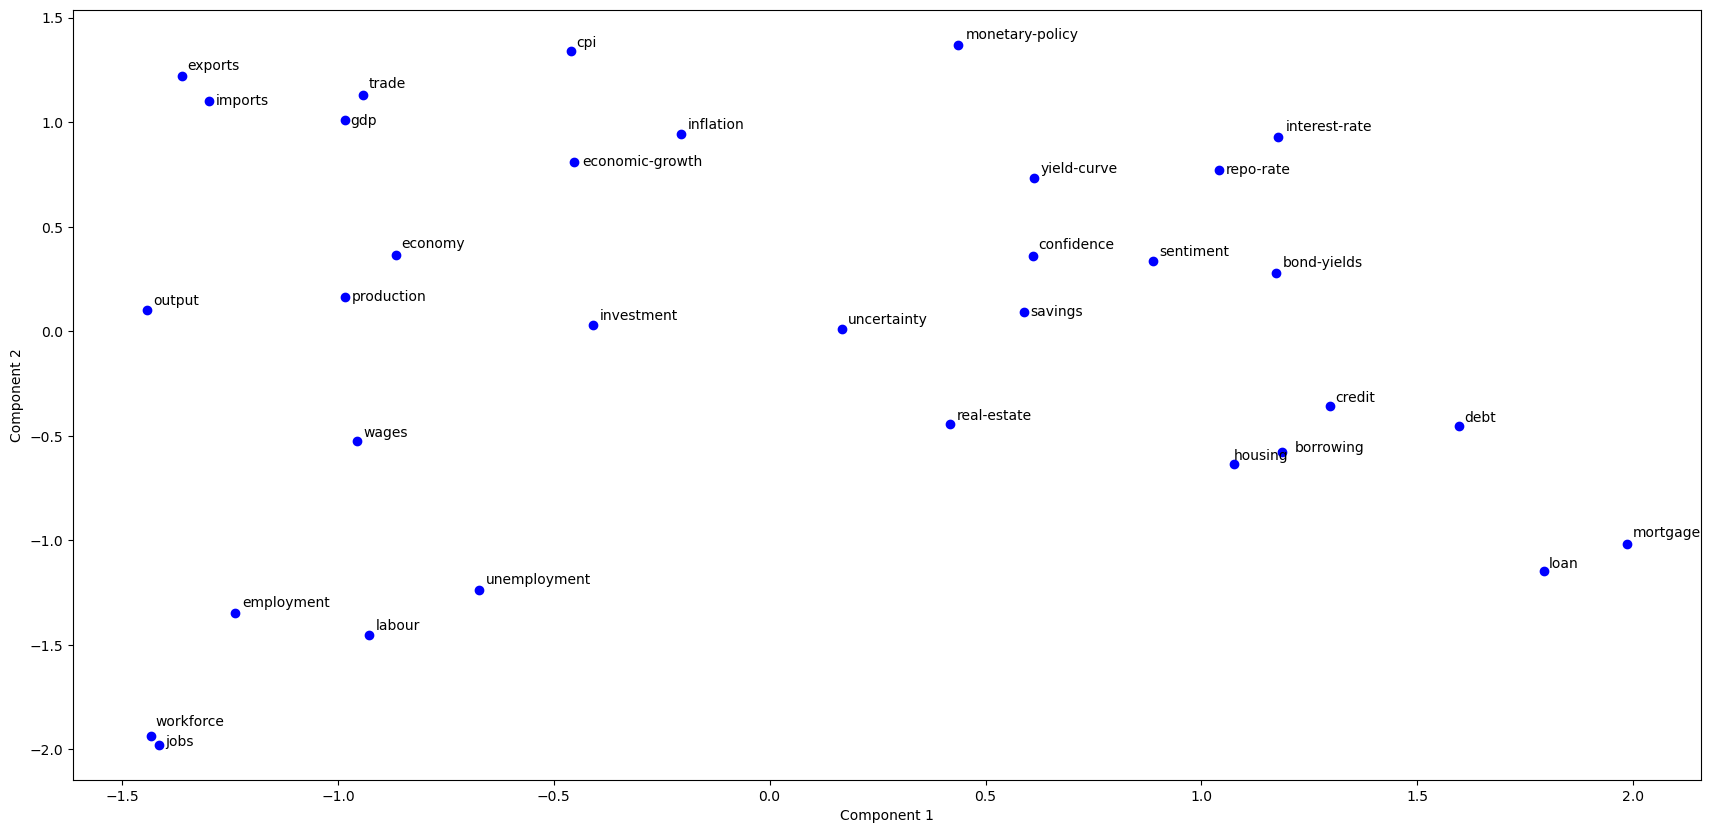

In [12]:
# define the tokens to use in the plot
tokens_of_interest = ['economy', 'gdp', 'production', 'output',
                      'investment', 'confidence', 'sentiment',
                      'uncertainty', 'inflation', 'cpi',
                      'loan', 'mortgage', 'credit', 'debt', 'savings', 
                      'borrowing', 'housing', 'labour', 'workforce', 
                      'unemployment', 'employment', 'jobs', 'wages',
                      'trade', 'exports', 'imports']

# define dictionary for preprocessing class with terms we want to preserve
replacing_dict = {'monetary policy':'monetary-policy',
                  'interest rate':'interest-rate',
                  'interest rates':'interest-rate',
                  'yield curve':'yield-curve',
                  'repo rate':'repo-rate',
                  'bond yields':'bond-yields',
                  'real estate':'real-estate',
                  'economic growth':'economic-growth'}

# expand the list of tokens with all the tokens from the replacement dictionary
tokens_of_interest = set(tokens_of_interest + list(replacing_dict.values()) )

# plot
pca_scatterplot(word_vectors, list(tokens_of_interest))

We can clearly observe how words form some thematically cohesive groups; trade (e.g. exports, imports, trade, output), job-market (e.g. workforce, jobs, employment), housing (e.g. real-state, housing, borrowing, mortgage).

## *Nearest neighbors analysis*

We can further explore how words cluster in the embedded space by analyzing the nearest neighbours of some selected words.

### 📐 How Word2Vec Measures Distance

After training, Word2Vec represents each word as a vector in a high-dimensional space. To measure how **similar** two words are, it compares the **distance** (more accurately, the angle) between their vectors.

#### ✅ Cosine Similarity (Default in Gensim)

Word2Vec uses **cosine similarity** by default:

$\text{cosine\_similarity}(A, B) = \frac{A \cdot B}{\|A\| \cdot \|B\|}$

Where:
- $A \cdot B$ is the dot product of the two vectors
- $\|A\|$ and $\|B\|$ are the magnitudes (norms) of the vectors

#### 🔍 Why Cosine?

- Cosine similarity measures the **angle** between two vectors, focusing on **direction**, not magnitude.
- This is ideal because **direction encodes meaning** in Word2Vec embeddings.
- Vector length may vary due to word frequency, but angle captures **semantic similarity**.

In [51]:
# find the K nearest neighbours of relevant words
K = 5
words = ["uncertainty", "risk", "stable",
         "contraction", "expansion",
         "monetary-policy", "interest-rate", "inflation"]

for word in words:
    results = []
    neighbors = word_vectors.most_similar(word, topn=K)
    for neighbor_word, similarity in neighbors:
        results.append({
            'Neighbor': neighbor_word,
            'Similarity': round(similarity, 4)
        })
    print(f"neighbors of '{word}':")
    print(pd.DataFrame(results))
    print('\n')

neighbors of 'uncertainty':
        Neighbor  Similarity
0    surrounding      0.6552
1      surrounds      0.6303
2  uncertainties      0.6213
3        tension      0.6161
4      uncertain      0.6077


neighbors of 'risk':
        Neighbor  Similarity
0          risks      0.7024
1    possibility      0.6915
2         posing      0.6615
3  possibilities      0.6544
4           pose      0.6543


neighbors of 'stable':
     Neighbor  Similarity
0  remarkably      0.7280
1    speaking      0.7205
2        flat      0.7082
3      fairly      0.7035
4  stabilised      0.6907


neighbors of 'contraction':
     Neighbor  Similarity
0  bounceback      0.7915
1  contracted      0.7617
2  destocking      0.7609
3    run-down      0.7458
4       surge      0.7424


neighbors of 'expansion':
   Neighbor  Similarity
0  vigorous      0.7655
1   upswing      0.7612
2     brisk      0.7610
3   briskly      0.7505
4    upturn      0.7436


neighbors of 'monetary-policy':
        Neighbor  Similarity

## *Analogy tasks*

A very interesting, and surprising, use of word embeddings is to find word analogies. The famous example used by [Mikolov et al. (2013)](https://arxiv.org/pdf/1301.3781.pdf) searches for a word $X$ in the embedded space that is similar to "woman" in the same sense that "king" is similar to "man". This task can be expressed in terms of a simple vector arithmetic problem as follows:

$$
\vec{King}^{\,} - \vec{Man}^{\,} = \vec{X}^{\,} - \vec{Woman}^{\,} \\
\vec{King}^{\,} - \vec{Man}^{\,} + \vec{Woman}^{\,} = \vec{X}^{\,}
$$

Mikolov et al. (2013) find that when performing this operation on their trained embeddings, they are able to recover the word "queen".

$$ \vec{King}^{\,} - \vec{Man}^{\,} + \vec{Woman}^{\,} \approx \vec{Queen}^{\,} $$

Using ```Gensim``` this operation can be very easily perfomed by simply using the ```.most_similar()``` function as follows:

<center>

```python
word_vectors.most_similar(positive=['king', 'woman'], negative=['man'])
```

</center>

We will play with this idea and try to extend it to our own domain. Some of the analogies that we will try to solve are: 

$$
\vec{Contraction}^{\,} - \vec{Expansion}^{\,} + \vec{Downward}^{\,} = \vec{X}^{\,} \\
\vec{Inflation}^{\,} - \vec{CPI}^{\,} + \vec{GDP}^{\,} = \vec{X}^{\,} \\
$$

In [47]:
# create the analogy tasks for our data
positive_words = [['contraction', 'downward'],
                  ['inflation', 'gdp'],
                  ['company', 'wages'],
                  ['expansion', 'tighten']]

negative_words = [['expansion'],
                  ['cpi'],
                  ['profits'],
                  ['contraction']]

for pw, nw in zip(positive_words, negative_words):
    #print(f"Analogy task for positive words: {pw} and negative words {nw}")
    results = []
    print(f"'{nw[0]}' is to '{pw[0]}' as '{pw[1]}' is to:")
    neighbors = word_vectors.most_similar(positive=pw, negative=nw)[:K]
    for neighbor_word, similarity in neighbors:
        results.append({
            'Analogy word': neighbor_word,
            'Similarity': round(similarity, 4)
        })
    print(pd.DataFrame(results))
    print("\n")

'expansion' is to 'contraction' as 'downward' is to:
           Analogy word  Similarity
0                upward      0.6891
1  faster-than-expected      0.6074
2            unaffected      0.5849
3               upwards      0.5784
4               pulling      0.5783


'cpi' is to 'inflation' as 'gdp' is to:
      Analogy word  Similarity
0   fourth-quarter      0.5543
1       moderately      0.5504
2  economic-growth      0.5492
3       sluggishly      0.5481
4      below-trend      0.5461


'profits' is to 'company' as 'wages' is to:
  Analogy word  Similarity
0      demands      0.5930
1         wage      0.5879
2   bargaining      0.5741
3      erosion      0.5699
4       recoup      0.5646


'contraction' is to 'expansion' as 'tighten' is to:
  Analogy word  Similarity
0      improve      0.6389
1       loosen      0.6204
2       expand      0.6039
3      thawing      0.5945
4         ease      0.5771




## *Building dictionaries*

One last use of word embeddings is to expand existing dictionaries by finding the nearest neighbours to a set of "center" terms. To illustrate this, we will come show how to generate dictionaries of positive and negative terms to analyze text data from the Bank of England Monetary Police Comittee minutes.

In [15]:
# create a positive dictionary by finding the nearest neighbors to a combination of relevant words
N = 20
pos_center_terms = ['expansion', 'stable']
pos_nn = [w for w, _ in word_vectors.most_similar(positive=pos_center_terms, topn=N)]
pos_word2vec = pos_center_terms + pos_nn
print(pos_word2vec)

['expansion', 'stable', 'steady', 'remarkably', 'robust', 'brisk', 'apace', 'resilient', 'vigorous', 'stagnation', 'sluggishness', 'healthily', 'decelerating', 'double-digit', 'soften', 'slackened', 'buoyed', 'loose', 'unevenly', 'non-japan', 'accelerating', 'tandem']


In [16]:
# create a negative dictionary by finding the nearest neighbors to a combination of relevant words
N = 20
neg_center_terms = ['contraction', 'uncertainty']
neg_nn = [w for w, _ in word_vectors.most_similar(positive=neg_center_terms, topn=N)]
neg_word2vec = neg_center_terms + neg_nn
print(neg_word2vec)

['contraction', 'uncertainty', 'sluggishness', 'destocking', 'bounceback', 'shallower', 'gentler', 'cushioned', 'faster-than-expected', 'worsening', 'softness', 'stronger-than-expected', 'bright', 'bounce-back', 'pause', 'solidity', 'ambiguous', 'slacken', 'nascent', 'spreading', 'wake', 'hot']


In [ ]:
# load the preprocessed tokens of mpc minutes
file_id = '1L0GmXSanSKOF625DHAx5Y3DcnXzU6Kpn'
url = f'https://drive.google.com/uc?id={file_id}'
df_minutes = pd.read_csv(url, header=None, names=['text'])
# Split each line into a list of tokens
df_minutes['tokens'] = df_minutes['text'].str.split()
prep_dict = df_minutes['tokens'].tolist()

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
def create_df_matrix(docs, max_df=1.0, min_df=1):
    """
    Create a document-term frequency matrix (not tf-idf) from tokenized documents,
    with filtering by document frequency thresholds.

    Parameters:
        docs (List[List[str]]): A list of tokenized documents
        max_df (float or int): Terms appearing in more than this proportion (or count) of docs are ignored
        min_df (float or int): Terms appearing in fewer than this proportion (or count) of docs are ignored

    Returns:
        matrix (np.ndarray): Document-term frequency matrix
        vocabulary (Dict): Mapping from term to column index
    """

    def dummy(doc):
        return doc

    vectorizer = TfidfVectorizer(
        use_idf=False,         # pure term frequency
        norm=None,             # do not normalize
        tokenizer=dummy,       # use tokens directly
        preprocessor=dummy,
        max_df=max_df,
        min_df=min_df
    )

    matrix = vectorizer.fit_transform(docs).toarray()
    vocab = vectorizer.vocabulary_

    return matrix, vocab

def pos_neg_counts(prep_dict, items, pos_terms, neg_terms, nlp_standard):

    # build the document-term matrix
    create_df_matrix(prep_dict, min_df=10)

    # find the position of the terms
    pos_ixs = [v for k,v in prep_dict.vocabulary[items].items() if k in pos_terms]
    neg_ixs = [v for k,v in prep_dict.vocabulary[items].items() if k in neg_terms]

    # count positive terms
    pos_counts = np.take(prep_dict.df_matrix[items], pos_ixs, axis=1)
    pos_counts = pos_counts.sum(axis=1)

    # count negative terms
    neg_counts = np.take(prep_dict.df_matrix[items], neg_ixs, axis=1)
    neg_counts = neg_counts.sum(axis=1)
    
    return pos_counts, neg_counts

In [40]:
# generate the count of positive and negative tokens in the corpus with our new dictionaries
import spacy
nlp_standard = spacy.load('en_core_web_sm')
pos_counts_word2vec, neg_counts_word2vec = pos_neg_counts(prep_dict, 
                                                          items="tokens",
                                                          pos_terms=pos_word2vec, 
                                                          neg_terms=neg_word2vec,
                                                          nlp_standard=nlp_standard)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


AttributeError: 'list' object has no attribute 'vocabulary'

In [42]:
# add counts to the data
data_dict['pos_counts_word2vec'] = pos_counts_word2vec
data_dict['neg_counts_word2vec'] = neg_counts_word2vec
data_dict

,date,minutes,year,quarter,pos_counts_word2vec,neg_counts_word2vec
0,199706,1 Sections I to V of this minute summarise t...,1997,2,0.0,0.0
1,199706,The 12-month growth rate of notes and coins ...,1997,2,0.0,0.0
2,199706,"Broad money, too, decelerated in April: its ...",1997,2,0.0,0.0
3,199706,Lending growth continued at around 9% in ...,1997,2,0.0,0.0
4,199706,Lending to individuals remained robust in...,1997,2,1.0,0.0
...,...,...,...,...,...,...
7272,201410,"For most members, there remained insuffi...",2014,4,1.0,0.0
7273,201410,"Set against this, the level of Bank Rate...",2014,4,1.0,0.0
7274,201410,"For two members, economic circumstances ...",2014,4,1.0,0.0
7275,201410,The Governor invited the Committee to vo...,2014,4,0.0,0.0


In [43]:
# Apel and Blix-Grimaldi (2012) dictionaries
pos_words_AB = ["high", "higher", "highest",
                "strong", "stronger", "strongest",
                "increase", "increases", "increased","increasing",
                "fast", "faster", "fastest"]

neg_words_AB = ["low", "lower", "lowest",
                "weak", "weaker", "weakest",
                "decrease", "decreases", "decreased", "decreasing",
                "slow", "slower", "slowest"]

# generate the count of positive and negative lemmas in the corpus with Apel and Blix-Grimaldi (2012)
pos_counts_AB, neg_counts_AB = dictionary_methods.pos_neg_counts(prep_dict, 
                                              items="tokens",
                                              pos_terms=pos_words_AB, 
                                              neg_terms=neg_words_AB,
                                              nlp_standard=nlp_standard)

# add counts to the data
data_dict['pos_counts_AB'] = pos_counts_AB
data_dict['neg_counts_AB'] = neg_counts_AB
data_dict.head()

,date,minutes,year,quarter,pos_counts_word2vec,neg_counts_word2vec,pos_counts_AB,neg_counts_AB
0,199706,1 Sections I to V of this minute summarise t...,1997,2,0.0,0.0,0.0,0.0
1,199706,The 12-month growth rate of notes and coins ...,1997,2,0.0,0.0,0.0,0.0
2,199706,"Broad money, too, decelerated in April: its ...",1997,2,0.0,0.0,2.0,0.0
3,199706,Lending growth continued at around 9% in ...,1997,2,0.0,0.0,1.0,0.0
4,199706,Lending to individuals remained robust in...,1997,2,1.0,0.0,1.0,0.0


In [44]:
# aggregate to year-month level
data_agg = data_dict.groupby(['date']).agg({'pos_counts_word2vec': 'sum', 'neg_counts_word2vec': 'sum',
                                            'pos_counts_AB': 'sum', 'neg_counts_AB': 'sum',
                                            'year': 'mean', 'quarter':'mean'})
data_agg.head()

,pos_counts_word2vec,neg_counts_word2vec,pos_counts_AB,neg_counts_AB,year,quarter
date,,,,,,
199706,4.0,2.0,27.0,10.0,1997.0,2.0
199707,2.0,0.0,80.0,25.0,1997.0,3.0
199708,4.0,7.0,73.0,19.0,1997.0,3.0
199709,6.0,6.0,67.0,26.0,1997.0,3.0
199710,5.0,7.0,89.0,34.0,1997.0,4.0


In [45]:
# aggregate to year-quarter level removing incomplete quarters 
data_agg['months_x_quarter'] = 1
data_agg = data_agg.groupby(['year', 'quarter']).sum()[['pos_counts_word2vec', 'neg_counts_word2vec',
                                                        'pos_counts_AB', 'neg_counts_AB',
                                                        'months_x_quarter']]

data_agg = data_agg[data_agg['months_x_quarter']==3]
del data_agg['months_x_quarter']

data_agg.head()

pos_counts_word2vec  neg_counts_word2vec  pos_counts_AB  \
year   quarter                                                            
1997.0 3.0                     12.0                 13.0          220.0   
       4.0                     15.0                 22.0          228.0   
1998.0 1.0                     23.0                 27.0          251.0   
       2.0                     30.0                 22.0          251.0   
       3.0                     21.0                 17.0          264.0   

                neg_counts_AB  
year   quarter                 
1997.0 3.0               70.0  
       4.0               84.0  
1998.0 1.0              109.0  
       2.0              127.0  
       3.0              128.0

In [46]:
# compute sentiment at year-quarter level
data_agg['sentiment_word2vec'] = (data_agg.pos_counts_word2vec - data_agg.neg_counts_word2vec)/(data_agg.pos_counts_word2vec + data_agg.neg_counts_word2vec)
data_agg['sentiment_AB'] = (data_agg.pos_counts_AB - data_agg.neg_counts_AB)/(data_agg.pos_counts_AB + data_agg.neg_counts_AB)
data_agg.head()

pos_counts_word2vec  neg_counts_word2vec  pos_counts_AB  \
year   quarter                                                            
1997.0 3.0                     12.0                 13.0          220.0   
       4.0                     15.0                 22.0          228.0   
1998.0 1.0                     23.0                 27.0          251.0   
       2.0                     30.0                 22.0          251.0   
       3.0                     21.0                 17.0          264.0   

                neg_counts_AB  sentiment_word2vec  sentiment_AB  
year   quarter                                                   
1997.0 3.0               70.0           -0.040000      0.517241  
       4.0               84.0           -0.189189      0.461538  
1998.0 1.0              109.0           -0.080000      0.394444  
       2.0              127.0            0.153846      0.328042  
       3.0              128.0            0.105263      0.346939

Next we add quarterly GDP data collected from the ONS website.

In [47]:
# prepare GDP data
ons = pd.read_csv('ons_quarterly_gdp.csv', names=['label', 'gdp_growth', 'quarter_long'], header=0)
ons['year'] = ons.label.apply(lambda x: x[:4]).astype(int)
ons['quarter'] = ons.label.apply(lambda x: x[6]).astype(int)
ons = ons[['year', 'quarter', 'gdp_growth']]
ons = ons.drop_duplicates().reset_index(drop=True).copy()
ons.head()

,year,quarter,gdp_growth
0,1997,2,1.2
1,1997,3,0.6
2,1997,4,1.3
3,1998,1,0.6
4,1998,2,0.6


In [48]:
# merge to sentiment data
df = data_agg.merge(ons, how='left', on=['year', 'quarter']).copy()

# create year-quarter variable
df["year_quarter"] = df.apply(lambda x: f"{int(x['quarter'])}Q{int(x['year'])}", axis=1)
df["year_quarter"] = df["year_quarter"].apply(lambda x: pd.Period(value=x, freq="Q").to_timestamp())
df.head()

,year,quarter,pos_counts_word2vec,neg_counts_word2vec,pos_counts_AB,neg_counts_AB,sentiment_word2vec,sentiment_AB,gdp_growth,year_quarter
0,1997.0,3.0,12.0,13.0,220.0,70.0,-0.040000,0.517241,0.6,1997-07-01
1,1997.0,4.0,15.0,22.0,228.0,84.0,-0.189189,0.461538,1.3,1997-10-01
2,1998.0,1.0,23.0,27.0,251.0,109.0,-0.080000,0.394444,0.6,1998-01-01
3,1998.0,2.0,30.0,22.0,251.0,127.0,0.153846,0.328042,0.6,1998-04-01
4,1998.0,3.0,21.0,17.0,264.0,128.0,0.105263,0.346939,0.7,1998-07-01


In [49]:
print(df[['gdp_growth', 'sentiment_AB', 'sentiment_word2vec']].corr())

                    gdp_growth  sentiment_AB  sentiment_word2vec
gdp_growth            1.000000      0.296561            0.431459
sentiment_AB          0.296561      1.000000            0.332324
sentiment_word2vec    0.431459      0.332324            1.000000


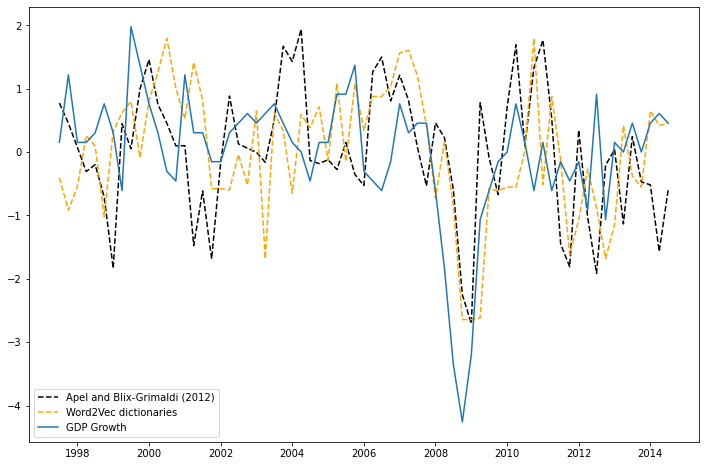

In [50]:
# standardize and plot all series
scaler = StandardScaler()

fig, ax = plt.subplots(figsize=(12,8))
ax.plot(df["year_quarter"], scaler.fit_transform(df.sentiment_AB.values.reshape(-1, 1)), 
                                                 label="Apel and Blix-Grimaldi (2012)", linestyle='dashed', c='black')

ax.plot(df["year_quarter"], scaler.fit_transform(df.sentiment_word2vec.values.reshape(-1, 1)), 
                                                 label="Word2Vec dictionaries", linestyle='dashed', c='orange')

ax.plot(df["year_quarter"], scaler.fit_transform(df.gdp_growth.values.reshape(-1, 1)), label="GDP Growth")

plt.legend()
plt.show()